In [2]:
!pip install --q lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.7 MB/s eta 0:00:00


In [25]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Modeling libraries
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

In [5]:
np.random.seed(42)

n = 1200
today = pd.Timestamp("2025-11-01")

listing_dates = np.random.choice(pd.date_range("2025-01-01", "2025-10-31"), size=n)

# Unit/listing features
bedrooms = np.random.choice([1,2,3], size=n, p=[0.55, 0.35, 0.10])
sqft = (bedrooms * 350 + np.random.normal(0, 50, size=n)).astype(int)
relative_price = np.clip(np.random.normal(1.0, 0.18, size=n), 0.6, 1.6)  # 1.0 = market median
views_7d = np.maximum(0, np.random.poisson(18 - 6*(relative_price-1.0)))
inquiries_7d = np.maximum(0, np.random.poisson(views_7d * 0.07))
maint_90 = np.random.poisson(0.25, size=n)
recent_reno = np.random.binomial(1, 0.08, size=n)
month = pd.to_datetime(listing_dates).month
summer = ((month >= 5) & (month <= 8)).astype(int)

In [6]:
# Construct a linear predictor that will influence hazard (higher -> shorter TTL)
# We pick coefficients so the signal is reasonable
lp = -0.45 * inquiries_7d + 1.2 * (relative_price - 1.0) + 0.35 * maint_90 - 0.25 * summer - 0.15 * recent_reno + 0.2*(bedrooms-1)
lp = (lp - lp.mean()) / (lp.std() + 1e-9)  # standardize LP

In [10]:
# Baseline rate (exponential-ish). Larger rate => shorter time
baseline_lambda = 1/28.0
rate_multiplier = np.exp(-1.0 * lp)  # invert sign so more inquiries => higher hazard (shorter time)
# sample time to event (days) from exponential with varying scale
sim_days = np.random.exponential(scale=1.0/(baseline_lambda * rate_multiplier + 1e-9))

In [11]:
# Censoring at observation cutoff (today)
days_since_listing = (pd.to_datetime(today) - pd.to_datetime(listing_dates)).days
observed_days = np.minimum(sim_days, days_since_listing)
event = (sim_days <= days_since_listing).astype(int)  # 1 if leased within observed window

df = pd.DataFrame({
    "listing_date": listing_dates,
    "days_since_listing": days_since_listing,
    "days_to_lease": np.round(observed_days).astype(int),
    "event": event,
    "bedrooms": bedrooms,
    "sqft": sqft,
    "relative_price": relative_price,
    "views_7d": views_7d,
    "inquiries_7d": inquiries_7d,
    "maint_90": maint_90,
    "recent_reno": recent_reno,
    "summer": summer
})

# Clip days_to_lease >= 0
df["days_to_lease"] = df["days_to_lease"].clip(lower=0)

In [12]:
df.head()

,listing_date,days_since_listing,days_to_lease,event,bedrooms,sqft,relative_price,views_7d,inquiries_7d,maint_90,recent_reno,summer
0,2025-04-13,202,167,1,2,679,0.841560,20,0,0,0,0
1,2025-09-28,34,0,1,2,696,0.773143,28,1,0,0,0
2,2025-04-17,198,198,0,2,727,1.152822,21,0,0,0,0
3,2025-03-13,233,29,1,2,744,0.981057,21,0,0,0,0
4,2025-07-08,116,4,1,3,1100,0.763549,20,3,1,0,1


In [13]:
num_cols = ["sqft", "relative_price", "views_7d", "inquiries_7d", "maint_90"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [14]:
df.head()

,listing_date,days_since_listing,days_to_lease,event,bedrooms,sqft,relative_price,views_7d,inquiries_7d,maint_90,recent_reno,summer
0,2025-04-13,202,167,1,2,0.585901,-0.893734,0.437452,-1.056896,-0.499765,0,0
1,2025-09-28,34,0,1,2,0.658517,-1.285241,2.286653,-0.225240,-0.499765,0,0
2,2025-04-17,198,198,0,2,0.790935,0.887420,0.668602,-1.056896,-0.499765,0,0
3,2025-03-13,233,29,1,2,0.863552,-0.095480,0.668602,-1.056896,-0.499765,0,0
4,2025-07-08,116,4,1,3,2.384225,-1.340142,0.437452,1.438071,1.453713,0,1


In [15]:
cph = CoxPHFitter()
# lifelines expects duration_col and event_col names passed to .fit
cph.fit(df[["days_to_lease", "event"] + num_cols + ["bedrooms", "recent_reno", "summer"]],
        duration_col="days_to_lease", event_col="event", show_progress=True)
print("=== Cox PH Summary ===")
print(cph.summary.round(4))

Iteration 1: norm_delta = 1.18e+00, step_size = 0.9500, log_lik = -6478.50032, newton_decrement = 3.67e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.92e-01, step_size = 0.9500, log_lik = -6165.11312, newton_decrement = 1.89e+01, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.92e-02, step_size = 0.9500, log_lik = -6145.84525, newton_decrement = 1.66e-01, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.19e-04, step_size = 1.0000, log_lik = -6145.67869, newton_decrement = 6.32e-06, seconds_since_start = 0.2
Iteration 5: norm_delta = 7.62e-09, step_size = 1.0000, log_lik = -6145.67869, newton_decrement = 2.44e-14, seconds_since_start = 0.2
Convergence success after 5 iterations.
=== Cox PH Summary ===
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
sqft            0.1430     1.1537    0.1422         -0.1358          0.4217   
relative_price -0.3013     0.7

In [17]:
results_ph = proportional_hazard_test(cph, df[["days_to_lease", "event"] + num_cols + ["bedrooms", "recent_reno", "summer"]], time_transform='rank')
print("\n=== Proportional hazards test (p-values): ===")
print(results_ph.print_summary())


=== Proportional hazards test (p-values): ===


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1200 total observations, 152 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
bedrooms                  3.07 0.08      3.65
inquiries_7d              0.09 0.76      0.39
maint_90                  0.52 0.47      1.08
recent_reno               1.12 0.29      1.79
relative_price            2.30 0.13      2.95
sqft                      2.99 0.08      3.58
summer                    0.50 0.48      1.06
views_7d                  0.53 0.47      1.10

None


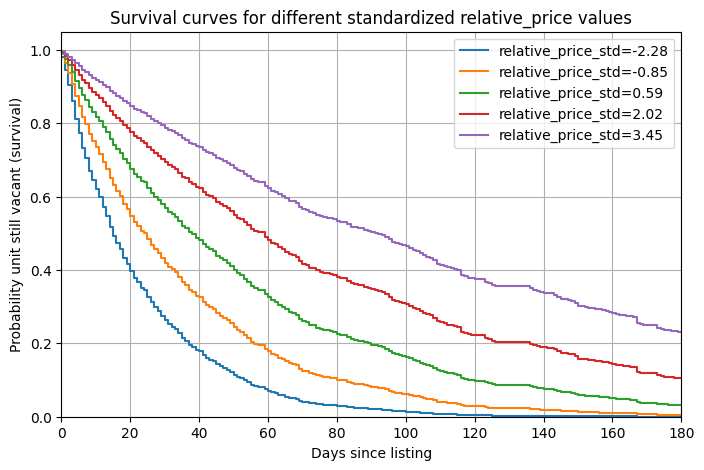


=== Quick interpretation (coef sign and HR) ===
sqft: coef=0.143, HR=1.154
relative_price: coef=-0.301, HR=0.740
views_7d: coef=0.008, HR=1.008
inquiries_7d: coef=0.823, HR=2.277
maint_90: coef=-0.276, HR=0.759
bedrooms: coef=-0.555, HR=0.574
recent_reno: coef=0.190, HR=1.209
summer: coef=0.397, HR=1.488

Data sample:
listing_date  days_since_listing  days_to_lease  event  bedrooms     sqft  relative_price  views_7d  inquiries_7d  maint_90  recent_reno  summer
  2025-04-13                 202            167      1         2 0.585901       -0.893734  0.437452     -1.056896 -0.499765            0       0
  2025-09-28                  34              0      1         2 0.658517       -1.285241  2.286653     -0.225240 -0.499765            0       0
  2025-04-17                 198            198      0         2 0.790935        0.887420  0.668602     -1.056896 -0.499765            0       0
  2025-03-13                 233             29      1         2 0.863552       -0.095480  0.668602

In [26]:
rp_values = np.linspace(df["relative_price"].min(), df["relative_price"].max(), 5)
# We'll keep other numeric covariates at their means (0 after scaling) and set example bedrooms
base_row = {
    "sqft": 0.0,
    "relative_price": 0.0,
    "views_7d": 0.0,
    "inquiries_7d": 0.0,
    "maint_90": 0.0,
    "bedrooms": 2,
    "recent_reno": 0,
    "summer": 0
}

# Build DataFrame of covariate sets
rows = []
for rv in rp_values:
    r = base_row.copy()
    r["relative_price"] = rv
    rows.append(r)
cov_df = pd.DataFrame(rows)

# Predict survival functions (returns a DataFrame: index = timeline, cols = each covariate row)
surv_funcs = cph.predict_survival_function(cov_df, times=np.arange(0, 181))  # up to 180 days
# Plot
plt.figure(figsize=(8,5))
for i, col in enumerate(surv_funcs.columns):
    plt.step(surv_funcs.index, surv_funcs[col], where="post", label=f"relative_price_std={rp_values[i]:.2f}")
plt.xlabel("Days since listing")
plt.ylabel("Probability unit still vacant (survival)")
plt.title("Survival curves for different standardized relative_price values")
plt.legend()
plt.ylim(0,1.05)
plt.xlim(0, 180)
plt.grid(True)
plt.show()

# --- Print simple interpretation
print("\n=== Quick interpretation (coef sign and HR) ===")
for cov in cph.summary.index:
    coef = cph.params_[cov]
    hr = np.exp(coef)
    print(f"{cov}: coef={coef:.3f}, HR={hr:.3f}")

# --- show data sample
print("\nData sample:")
print(df.head(6).to_string(index=False))